In [7]:
# 首先加载必用的库
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba # 结巴分词
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")
# 用来解压
import bz2
import tensorflow
from gensim.models import word2vec
from gensim.models import fasttext
import sklearn
import pandas as pd

**预训练词向量**  
本教程使用了北京师范大学中文信息处理研究所与中国人民大学 DBIIR 实验室的研究者开源的"chinese-word-vectors" github链接为：  
https://github.com/Embedding/Chinese-Word-Vectors  
如果你不知道word2vec是什么，我推荐以下一篇文章：  
https://zhuanlan.zhihu.com/p/26306795  
这里我们使用了"chinese-word-vectors"知乎Word + Ngram的词向量，可以从上面github链接下载，我们先加载预训练模型并进行一些简单测试：

In [2]:
# 请将下载的词向量压缩包放置在根目录 embeddings 文件夹里
# 解压词向量, 有可能需要等待1-2分钟
import time
start  = time.time()
with open("embeddings/sgns.zhihu.bigram", 'wb') as new_file, open("embeddings/sgns.zhihu.bigram.bz2", 'rb') as file:
    decompressor = bz2.BZ2Decompressor()
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(decompressor.decompress(data))
end = time.time()

print ("花费时间：",(end - start)/60,"mins")

花费时间： 0.6230101784070333 mins


In [3]:
# 使用gensim加载预训练中文分词embedding, 有可能需要等待1-2分钟
time1 = time.time()
cn_model = KeyedVectors.load_word2vec_format('embeddings/sgns.zhihu.bigram',
                                             binary=False, unicode_errors="ignore")
time2 = time.time()
print("花费时间:",(time2 - time1)/60,'mins')

花费时间: 1.3036367893218994 mins


**词向量模型**  
在这个词向量模型里，每一个词是一个索引，对应的是一个长度为300的向量，我们今天需要构建的LSTM神经网络模型并不能直接处理汉字文本，需要先进行分次并把词汇转换为词向量，步骤请参考下图，步骤的讲解会跟着代码一步一步来，如果你不知道RNN，GRU，LSTM是什么，我推荐deeplearning.ai的课程，网易公开课有免费中文字幕版，但我还是推荐有习题和练习代码部分的的coursera原版：  
<img src='flowchart.jpg' style='width:400px;'>

Cosine Similarity for Vector Space Models by Christian S. Perone
http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/

In [5]:
# 计算相似度 - cos(x,y)
cn_model.similarity('橘子', '橙子')

0.66128117

In [6]:
cn_model.similarity('国王','王子')

0.4895461

### 上面的相识度的计算是按照余弦相识度的计算实现：cos(x,y) = (x.y)/(abs(x)*abs(y))

In [7]:
#cn_model['橘子'] => 是一个1*embedding_dims 的向量

In [8]:
# dot（'橘子'/|'橘子'|， '橙子'/|'橙子'| ）
np.dot(cn_model['橘子']/np.linalg.norm(cn_model['橘子']), 
cn_model['橙子']/np.linalg.norm(cn_model['橙子']))

0.66128117

In [9]:
# 找出最相近的词，余弦相似度
cn_model.most_similar(positive=['计算机'], topn=10)

[('图形学', 0.6659187078475952),
 ('计算机技术', 0.6460264921188354),
 ('软件工程', 0.6406547427177429),
 ('微电子', 0.6350466012954712),
 ('自动控制', 0.6313568353652954),
 ('机械工程', 0.6216508150100708),
 ('数字电路', 0.6193503141403198),
 ('通信工程', 0.6179863214492798),
 ('计算机语言', 0.6152951717376709),
 ('计算机科学', 0.6142673492431641)]

In [10]:
# 找出不同的词
test_words = '歹徒 老师 会计师 程序员 律师 医生 '
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

在 歹徒 老师 会计师 程序员 律师 医生  中:
不是同一类别的词为: 歹徒


In [11]:
cn_model.most_similar(positive=['女人','美女'], negative=['男人'], topn=6)

[('帅哥', 0.5870201587677002),
 ('美人', 0.5252472162246704),
 ('大美女', 0.5057994723320007),
 ('靓女', 0.48884159326553345),
 ('丑男', 0.4734836220741272),
 ('美人儿', 0.4580216407775879)]

### 索引和词语之间的对应关系

In [6]:
cn_model.vocab["宾馆"].index,cn_model.index2word[7224]

(7224, '宾馆')

### ！！乱入 加载10w条微博2分类数据样本 ==========

In [16]:
###加载数据集合####
import pandas as pd
path = './git下载的数据集合/weibo_senti_100k/weibo_senti_100k.csv'
data_pd = pd.read_csv(path)
data_pd.head()

,label,review
0,1,﻿更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你]
1,1,@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...
2,1,姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢/...
3,1,美~~~~~[爱你]
4,1,梦想有多大，舞台就有多大![鼓掌]


In [4]:
# 现在我们将所有的评价内容放置到一个list里
# 这里和视频课程不一样, 因为很多同学反应按照视频课程里的读取方法会乱码,
# 经过检查发现是原始文本里的编码是gbk造成的,
# 这里我进行了简单的预处理, 以避免乱码
train_texts_orig = []
# 文本所对应的labels, 也就是标记
train_target = []
pos_length = []
neg_length  = []
with open("positive_samples.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        pos_length.append(len(dic["text"]))
        train_texts_orig.append(dic["text"])
        train_target.append(dic["label"])

with open("negative_samples.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        neg_length.append(len(dic["text"]))
        train_texts_orig.append(dic["text"])
        train_target.append(dic["label"])

# 新增加的数据样本 - 1403个样本，其中正面样本 neg_nums+pos_nums = 515 + 888 
with open("./Newdatas/mt_217356_Filters.txt", "r", encoding="utf-8") as f1: # 每个样本长度大约50
    lines = f1.readlines()
    for line in lines:
        item= line.split('/')
        train_target.append(item[0])
        train_texts_orig.append(item[1])
        if item[0] == '1':
            pos_length.append(1)
        else:
            neg_length.append(0)
        
# 新增加的数据-
with open("./Newdatas/newdatas/hotel/pos.txt",'r',encoding= 'utf-8') as f2:
    for line in f2.readlines():
        if len(line)>50:
            train_texts_orig.append(line)
            train_target.append(1)
            pos_length.append(len(line))

with open("./Newdatas/newdatas/hotel/neg.txt",'r',encoding= 'utf-8') as f3:
    for line in f3.readlines():
        if len(line)>50:
            train_texts_orig.append(line)
            train_target.append(0)
            neg_length.append(len(line))

## 新增加的美团爬取的数据，正面样本2347，负面样本1603，长度已经大约50
# postive 
with open("./Newdatas/meituan/contentMergedPostive.txt",'r',encoding = 'utf-8' ) as f4:
    for line in f4.readlines():
        train_texts_orig.append(line)
        train_target.append(1)
        pos_length.append(len(line))
f4.close()

# negative 
with open('./Newdatas/meituan/contentMergedNeg.txt','r',encoding = 'utf-8' ) as f4:
    for line in f4.readlines():
        train_texts_orig.append(line)
        train_target.append(0)
        neg_length.append(len(line))
f4.close()

# 添加的大众点评的数据 - 全是正面的 - 714
# postive 
with open("./Newdatas/dianping/dianpindata_allmerged.txt",'r',encoding = 'utf-8' ) as f5:
    for line in f5.readlines():
        train_texts_orig.append(line)
        train_target.append(1)
        pos_length.append(len(line))
f5.close()

In [8]:
train_target[8000]

1

In [9]:
train_texts_orig[800]

'酒店地理位置：4分，地理位置一般，离火车站文殊院较近，出租车相对比较好叫，大约等5分钟左右。\n\n酒店环境：5分，很有味道的芙蓉文化主题酒店，很有特色，个人很喜欢，就是作为4星级酒店来说服务态度稍微差了一点。'

### 下面是样本长度的大小统计 - 确定输入模型的文本长度时，并不是按照样本长度来计算的，而是下面的token[也就是已数据清洗以后的数据]

In [174]:
lens = np.array(neg_length + pos_length)
np.mean(lens),lens.min(),lens.max(),lens.mean() + 2*np.std(lens),len(lens),len(pos_length),len(neg_length)

(129.28333233729757, 0, 3008, 400.8825197827347, 16733, 9653, 7080)

In [64]:
means = lens.mean() + 2*np.std(lens)
print ("百分比:",(np.sum(lens<300))/len(lens)*100,"%")

百分比: 92.0396820653798 %


In [12]:
train_texts_orig[8900]

'说实话 初次到绍兴，住这个酒店比较好，为什么呢，因为离景点都比较近，条件还不错，房子比较有特色，只是楼道慢陡的，接送的师傅人比较好，服务员也还不错。\n'

In [89]:
"这个样本对应的标签label 值时: - 负面的评论标签设为零"
train_target[8900]

1

In [13]:
print("下面的是正面样本：")
train_texts_orig[3]

下面的是正面样本：


'总的来说，这样的酒店配这样的价格还算可以，希望他赶快装修，给我的客人留些好的印象'

In [14]:
"正面样本对应的label - 值等于一"
train_target[3]

1

In [138]:
print("样本长度:",len(train_texts_orig),";","标签长度:",len(train_target))

样本长度: 16733 ; 标签长度: 16733


In [93]:
# 我们使用tensorflow的keras接口来建模  - 下面的代码可以执行
#from tensorflow.contrib.keras.python.keras.models import Sequential
#from tensorflow.contrib.keras.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
#from tensorflow.contrib.keras.python.keras.preprocessing.text import Tokenizer
#from tensorflow.contrib.keras.python.keras.preprocessing.sequence import pad_sequences
#from tensorflow.contrib.keras.python.keras.optimizers import RMSprop
#from tensorflow.contrib.keras.python.keras.optimizers import Adam
#from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [10]:
# 我们使用tensorflow的keras接口来建模 - 下面的代码在当前执行不通
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

**分词和tokenize**  
首先我们去掉每个样本的标点符号，然后用jieba分词，jieba分词返回一个生成器，没法直接进行tokenize，所以我们将分词结果转换成一个list，并将它索引化[每一个词对应为一个索引数组，一个样本就对应成一段索引数字]，这样每一例评价的文本变成一段索引数字，对应着预训练词向量模型中的词。

### 数据清晰

In [12]:
# 进行分词和tokenize
# train_tokens是一个长长的list，其中含有4000个小list，对应每一条评价
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、""【】~@#￥%……&*（）]+", "",text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)
# train_tokens 格式= [[样本1 索引序列],[样本2 索引序列],.....[样本n索引序列] ]

In [18]:
train_texts_orig[4500]  # "这个样本映射成下面一段索引序列"

'服务差 早上退房前台跟欠她钱似的，开完发票，手机就往那一扔，发票开完直接往手机上一放告诉我开完了，太差了，服务行业一点服务都没有，马桶水按不下去，空调有噪音，座机没有电话线，再也不去了\n'

In [19]:
"上面的这句话对应的索引序列是，比如第一个词宾馆==>对应的index值=7224"
np.array(train_tokens[4500])

array([ 1191,   710,  1001, 39390,  8241,   103,  4406,    47,   247,
        2632,   264,   566, 12457,   300,    38,   478,    89,    41,
        2073, 12457,   264,   566,   209,   478,   300,    24,     0,
         362,     0,   566,     3,  5915,     3, 28158,   177,  1191,
          11,    29,  6729,   548,   649,    10,   882,  2437,     8,
        8344, 32243,    29, 52968,  1126,     0,     3])

### 统计词汇表大小：也就是统计样本中有多少个灭有重复出现的词

In [13]:
vocab_tokens = []
for tokens in train_tokens:
    for token in tokens:
        if token not in vocab_tokens:
            vocab_tokens.append(token)
        else:
            pass
print("词汇表大小是：",len(vocab_tokens))

词汇表大小是： 28220


**索引长度标准化**  
因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评填充成同样的长度，这样十分浪费计算资源，所以我们取一个折衷的长度。

In [175]:
# 获得所有tokens的长度
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)
num_tokens

array([ 23,  86,  16, ..., 272, 115, 424])

In [176]:
# 平均tokens的长度
np.mean(num_tokens) # "相当于样本中的平均长度是71"

71.0492440088448

In [177]:
# 最长的评价tokens的长度
np.max(num_tokens)

1540

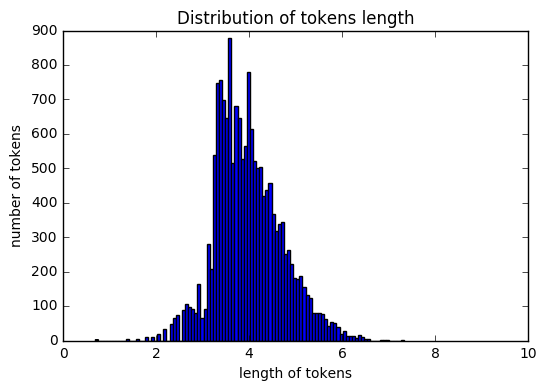

In [178]:
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [179]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

211

In [180]:
# 取tokens的长度为236时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.9591226916870854

**反向tokenize ==>将索引转换成文本内容**  
我们定义一个function，用来把索引转换成可阅读的文本，这对于debug很重要。

In [181]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [75]:
reverse = reverse_tokens(train_tokens[4500])

以下可见，训练样本的极性并不是那么精准，比如说下面的样本，对早餐并不满意，但被定义为正面评价，这会迷惑我们的模型，不过我们暂时不对训练样本进行任何修改。

In [76]:
# 经过tokenize再恢复成文本
# 可见标点符号都没有了
reverse

'服务差早上退房前台跟欠她钱似的开完发票手机就往那一扔发票开完直接往手机上 告诉 完了太差了服务行业一点服务都没有马桶水按不下去空调有噪音座机没有电话线再也 了'

In [77]:
# 原始文本
train_texts_orig[4500]

'服务差 早上退房前台跟欠她钱似的，开完发票，手机就往那一扔，发票开完直接往手机上一放告诉我开完了，太差了，服务行业一点服务都没有，马桶水按不下去，空调有噪音，座机没有电话线，再也不去了\n'

**准备Embedding Matrix**  
现在我们来为模型准备embedding matrix（词向量矩阵），根据keras的要求，我们需要准备一个维度为$(numwords, embeddingdim)$的矩阵，num words代表我们使用的词汇表的数量vocab_size，emdedding dimension在我们现在使用的预训练词向量模型中是300，每一个词汇都用一个长度为300的向量表示。  
注意我们只选择使用前50k个使用频率最高的词，在这个预训练词向量模型中，一共有260万词汇量，如果全部使用在分类问题上会很浪费计算资源，因为我们的训练样本很小，一共只有4k，如果我们有100k，200k甚至更多的训练样本时，在分类问题上可以考虑减少使用的词汇量。

### 下面这个构建了词嵌入矩阵 Embedding Martix

In [141]:
# 只使用前50000个词
embedding_dim = 300  #"词嵌入维度"
num_words     = 50000 # 词汇表大小
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [142]:
words = cn_model.index2word[1]
#cn_model[words] == (embedding_matrix[1,:]) => is equal with each others

In [143]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum( cn_model[cn_model.index2word[333]] == embedding_matrix[333] )

300

In [144]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

(50000, 300)

**padding（填充）和truncating（修剪）**  
我们把文本转换为tokens（索引）之后，每一串索引的长度并不相等，所以为了方便模型的训练我们需要把索引的长度标准化，上面我们选择了236这个可以涵盖95%训练样本的长度，接下来我们进行padding和truncating，我们一般采用'pre'的方法，这会在文本索引的前面填充0，因为根据一些研究资料中的实践，如果在文本索引后面填充0的话，会对模型造成一些不良影响。

In [182]:
# 进行padding和truncating,输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
print("pad前的长度:",len(train_tokens[33]))
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,  # 将文本补齐成max_tokens 的样子
                            padding='pre', truncating='pre')
print(train_pad[33])
print("pad后的长度:",len(train_pad[33]))

pad前的长度: 83
[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0    290   3053
     57    169     73      1     25  11216     49    163  15985 2

In [147]:
# 超出五万个词向量的词用0代替
train_pad[ train_pad>=num_words ] = 0

In [183]:
# 可见padding之后前面的tokens全变成0，文本在最后面
train_pad[33]  # 长度是max_tokens = 211

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [149]:
# 准备target向量，
train_target = np.array(train_target)

In [150]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split

In [151]:
# 90%的样本用来训练，剩余10%用来测试
X_train, X_test, y_train, y_test = train_test_split(train_pad,   #236 长度
                                                    train_target,#236 长度
                                                    test_size=0.2,
                                                    random_state=666)

In [152]:
# 查看训练样本，确认无误
print(reverse_tokens(X_train[3400]))
print('class: ',y_train[3400])

                                                               北京 山庄在北方 了其实偶尔也会向往一下南方的“江南风情 别致的江南小院静谧 着的那种江南味道令人着迷不过周末 上 江南那还是太远了些不过别担心咱北京也有这样的“江南风景北京 山庄位于 水长城附近 山庄小楼的设计和整个山庄的搭配真的给人  的感觉除了外部设计很具有江南风格外这里更有新意的是山庄的24 房是以24 命名 内都有店家自己手绘的 不说在这里过夜了 这种安静悠闲的环境中坐一下 茶  发呆那都不失为 享受啊 ：北京市 黄花  水长城
class:  1


现在我们用keras搭建LSTM模型，模型的第一层是Embedding层，只有当我们把tokens索引转换为词向量矩阵之后，才可以用神经网络对文本进行处理。
keras提供了Embedding接口，避免了繁琐的稀疏矩阵操作。   
在Embedding层我们输入的矩阵为：$$(batchsize, maxtokens)$$
输出矩阵为： $$(batchsize, maxtokens, embeddingdim)$$

In [153]:
# 用LSTM对样本进行分类
model = Sequential()

In [154]:
# 模型第一层为embedding
embedding_1st = Embedding(num_words, # num_words = 20000
                    embedding_dim,   # embedding_dim = 300
                    weights=[embedding_matrix], # embedding_matrix.shape = (20000,300)
                    input_length=max_tokens,#max_tokens = 211
                    trainable=False)
model.add(embedding_1st)
'''
Arguments:
input_dim: int > 0. Size of the vocabulary = nums_words = vocab_size 
output_dim: int >= 0. Dimension of the dense embedding/ embedding dims = 300
embeddings_initializer: Initializer for the `embeddings` matrix.
input_length:Length of input sequences, when it is constant.
 |        This argument is required if you are going to connect
 |        `Flatten` then `Dense` layers upstream
 |        (without it, the shape of the dense outputs cannot be computed).
 
 Input shape:
 |      2D tensor with shape: `(batch_size, sequence_length)
 Output shape:
 |      3D tensor with shape: `(batch_size, sequence_length, output_dim)`.
 
'''

'\nArguments:\ninput_dim: int > 0. Size of the vocabulary = nums_words = vocab_size \noutput_dim: int >= 0. Dimension of the dense embedding/ embedding dims = 300\nembeddings_initializer: Initializer for the `embeddings` matrix.\ninput_length:Length of input sequences, when it is constant.\n |        This argument is required if you are going to connect\n |        `Flatten` then `Dense` layers upstream\n |        (without it, the shape of the dense outputs cannot be computed).\n \n Input shape:\n |      2D tensor with shape: `(batch_size, sequence_length)\n Output shape:\n |      3D tensor with shape: `(batch_size, sequence_length, output_dim)`.\n \n'

In [155]:
# 在2019年6月10日修改了一些大坑的bug, 可能是数据的顺序变了, 
# 结果模型训练的效果没有去年最早的时候效果好了, 
# 有兴趣的同学可以调整一下模型参数, 看看会不会有更好的结果
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

**构建模型**  
我在这个教程中尝试了几种神经网络结构，因为训练样本比较少，所以我们可以尽情尝试，训练过程等待时间并不长：  
**GRU：**如果使用GRU的话，测试样本可以达到87%的准确率，但我测试自己的文本内容时发现，GRU最后一层激活函数的输出都在0.5左右，说明模型的判断不是很明确，信心比较低，而且经过测试发现模型对于否定句的判断有时会失误，我们期望对于负面样本输出接近0，正面样本接近1而不是都徘徊于0.5之间。  
**BiLSTM：**测试了LSTM和BiLSTM，发现BiLSTM的表现最好，LSTM的表现略好于GRU，这可能是因为BiLSTM对于比较长的句子结构有更好的记忆，有兴趣的朋友可以深入研究一下。  
Embedding之后第，一层我们用BiLSTM返回sequences，然后第二层16个单元的LSTM不返回sequences，只返回最终结果，最后是一个全链接层，用sigmoid激活函数输出结果。

In [156]:
# GRU的代码
#model.add(GRU(units=32, return_sequences=True))
#model.add(GRU(units=16, return_sequences=True))
#model.add(GRU(units=4, return_sequences=False))

In [157]:
model.add(Dense(1, activation='sigmoid'))
# 我们使用adam以0.001的learning rate进行优化
optimizer = Adam(lr=1e-2)

In [158]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

### 下面embedding 的输出维度是 128X236X300; 双向LSTM的输出维度(隐藏节点个数units=64) NoneXNoneX128

### LSTM_cell（隐藏节点=16）,输出的维度为NoneX16

In [159]:
# 我们来看一下模型的结构，一共90k左右可训练的变量
model.summary()  #

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 211, 300)          15000000  
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 128)         186880    
_________________________________________________________________
lstm_10 (LSTM)               (None, 16)                9280      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 15,196,177
Trainable params: 196,177
Non-trainable params: 15,000,000
_________________________________________________________________


In [160]:
# 建立一个权重的存储点
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [161]:
# 尝试加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

In [162]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [163]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-8, patience=0,
                                       verbose=1)

In [164]:
# 定义callback函数
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

In [165]:
# 开始训练
start =time.time()
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=200,
          batch_size=128,
          callbacks=callbacks)
end =time.time()
print("Fit Training Times:",(end -start)/60,"mins")

Train on 12047 samples, validate on 1339 samples
Epoch 1/200
12047/12047 [==============================] - 204s - loss: 0.2595 - acc: 0.8974 - val_loss: 0.1788 - val_acc: 0.9425
Epoch 2/200
12032/12047 [============================>.] - ETA: 0s - loss: 0.1425 - acc: 0.9544Epoch 00001: val_loss did not improve

Epoch 00001: reducing learning rate to 0.0009999999776482583.
12047/12047 [==============================] - 202s - loss: 0.1429 - acc: 0.9543 - val_loss: 0.2003 - val_acc: 0.9305
Epoch 3/200
12047/12047 [==============================] - 204s - loss: 0.1045 - acc: 0.9689 - val_loss: 0.1698 - val_acc: 0.9500
Epoch 4/200
12047/12047 [==============================] - 202s - loss: 0.0866 - acc: 0.9764 - val_loss: 0.1688 - val_acc: 0.9507
Epoch 5/200
12032/12047 [============================>.] - ETA: 0s - loss: 0.0784 - acc: 0.9791Epoch 00004: val_loss did not improve

Epoch 00004: reducing learning rate to 9.999999310821295e-05.
12047/12047 [==============================] - 201s

**结论**  
我们首先对测试样本进行预测，得到了还算满意的准确度。  
之后我们定义一个预测函数，来预测输入的文本的极性，可见模型对于否定句和一些简单的逻辑结构都可以进行准确的判断。

In [166]:
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

3347/3347 [==============================] - 21s    
Accuracy:95.31%


In [167]:
def predict_sentiment(text):
    print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
            if cut_list[i] >= 50000:
                cut_list[i] = 0
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('是一例正面评价','output=%.2f'%coef)
    else:
        print('是一例负面评价','output=%.2f'%coef)

In [168]:
test_list = [
    '酒店设施不是新的，服务态度很不好',
    '酒店卫生条件非常不好',
    '床铺非常舒适',
    '房间很凉，不给开暖气',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生',
    '因为过节所以要我临时加钱，比团购的价格贵',
    '空调不好用，外面的窗帘也是脏的',
    '位置在密云，还算比较好找。酒店在一个山脚下，像很多别墅的感觉。从酒店内可以有栈道直接登山。酒店里有十二种不同温泉，分别对应圆明园十二兽首。每种温泉的功效不同，人参、雄黄、芦荟，藏红花等等，看上去挺补的。酒店的自助特别棒，尤其是现烤的牛排和红烩海鲜很赞',
    '充电器和泳衣不慎落在了酒店 回家才想起来 联系了宾客服务中心 帮忙找到并顺丰到付 非常感谢',
    '刷房卡就餐 自助早餐偏中式更多 个人感觉一般 周末人比较多',
    '门口的安保人员很负责；入住后礼宾部会主动把行李送到客房 并对酒店的环境设施进行介绍；中午会给车辆挡风玻璃罩上遮阳板',
    '今天的天气不错，很适合出去玩耍，但是路上堵车了，我们在车里有说有笑也很开心',
    '我们在酒店尽情看着电影，但是厕所漏水了',
    '酒店好评',
    '真的很不错，主要是宽敞，环境安逸住得舒服',
    '北京三里屯通盈中心洲际酒店，位置不错对面就是太古里，周边有商场、餐饮、酒吧，白天还是晩上都非常的热闹'
]

for text in test_list:
    predict_sentiment(text)

酒店设施不是新的，服务态度很不好
是一例负面评价 output=0.01
酒店卫生条件非常不好
是一例负面评价 output=0.01
床铺非常舒适
是一例正面评价 output=0.95
房间很凉，不给开暖气
是一例负面评价 output=0.26
房间很凉爽，空调冷气很足
是一例正面评价 output=0.99
酒店环境不好，住宿体验很不好
是一例负面评价 output=0.01
房间隔音不到位
是一例负面评价 output=0.32
晚上回来发现没有打扫卫生
是一例正面评价 output=0.59
因为过节所以要我临时加钱，比团购的价格贵
是一例负面评价 output=0.04
空调不好用，外面的窗帘也是脏的
是一例负面评价 output=0.00
位置在密云，还算比较好找。酒店在一个山脚下，像很多别墅的感觉。从酒店内可以有栈道直接登山。酒店里有十二种不同温泉，分别对应圆明园十二兽首。每种温泉的功效不同，人参、雄黄、芦荟，藏红花等等，看上去挺补的。酒店的自助特别棒，尤其是现烤的牛排和红烩海鲜很赞
是一例正面评价 output=0.99
充电器和泳衣不慎落在了酒店 回家才想起来 联系了宾客服务中心 帮忙找到并顺丰到付 非常感谢
是一例正面评价 output=0.92
刷房卡就餐 自助早餐偏中式更多 个人感觉一般 周末人比较多
是一例负面评价 output=0.40
门口的安保人员很负责；入住后礼宾部会主动把行李送到客房 并对酒店的环境设施进行介绍；中午会给车辆挡风玻璃罩上遮阳板
是一例正面评价 output=0.99
今天的天气不错，很适合出去玩耍，但是路上堵车了，我们在车里有说有笑也很开心
是一例正面评价 output=1.00
我们在酒店尽情看着电影，但是厕所漏水了
是一例正面评价 output=0.97
酒店好评
是一例正面评价 output=0.96
真的很不错，主要是宽敞，环境安逸住得舒服
是一例正面评价 output=0.99
北京三里屯通盈中心洲际酒店，位置不错对面就是太古里，周边有商场、餐饮、酒吧，白天还是晩上都非常的热闹
是一例正面评价 output=0.99


**错误分类的文本**
经过查看，发现错误分类的文本的含义大多比较含糊，就算人类也不容易判断极性，如index为101的这个句子，好像没有一点满意的成分，但这例子评价在训练样本中被标记成为了正面评价，而我们的模型做出的负面评价的预测似乎是合理的。

In [145]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [146]:
y_actual = np.array(y_test)

In [147]:
# 找出错误分类的索引
misclassified = np.where( y_pred != y_actual )[0]

In [148]:
# 输出所有错误分类的索引
len(misclassified)
print(len(X_test))

1141


In [149]:
# 我们来找出错误分类的样本看看
idx=101
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

                                                                                                                                          7月19日入住酒店总体感觉较好不足之处如下1   的指示标志不明显而且要走很远2服务人员似乎不知道什么是主动见面打招呼 比起海景 要差的远我在酒店大厅走廊院子里见到酒店各个岗位的服务人员大部分都不知道应该主动和客人打招呼问好
预测的分类 1
实际的分类 1


In [151]:
idx=323
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

                                                                                                                                                                     在携程预定酒店这么多次遇到的 的酒店住在行政豪华房早上7 起来连洗澡的热水也没有 时说没有发票请携程帮帮忙不要把这种酒店放在你们网上害人谢谢
预测的分类 0
实际的分类 0
